# Spacenet8 EDA

## Overview
- pip dependency
- `.geojson` -> `geotif`
- vizualize image
- vizualize annotation 
- statistics

## Env

In [58]:
%%writefile requirements_eda.txt
# jupyterlab

# basic
joblib
numpy
pandas
tifffile
imagecodecs
rasterio
matplotlib
seaborn
tqdm

# data
# awscli


Overwriting requirements_eda.txt


In [59]:
!pip install -q -r requirements_eda.txt

In [7]:
!conda install -y gdal

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/syu/anaconda3/envs/sn8

  added / updated specs:
    - gdal


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cairo-1.16.0               |       h19f5f5c_2         1.1 MB
    cfitsio-3.470              |       h5893167_7         833 KB
    curl-7.82.0                |       h7f8727e_0          95 KB
    hdf5-1.10.6                |       h3ffc7dd_1         3.6 MB
    jpeg-9e                    |       h7f8727e_0         240 KB
    libboost-1.73.0            |      h28710b8_12        13.8 MB
    libcurl-7.82.0             |       h0b77cf5_0         342 KB
    libgdal-3.4.1              |       h05199a0_1        19.5 MB
    libgfortran

## Data

In [ ]:
# another env
# !aws s3 cp s3://spacenet-dataset/spacenet/SN8_floods/ ../data/ --recursive

In [5]:
!ls ../data/

Germany_Training_Public		Louisiana-West_Test_Public  tarballs
Louisiana-East_Training_Public	resolutions.txt


## Import

In [9]:
# check cli and version
!gdalinfo --version
!python --version

GDAL 3.4.1, released 2021/12/27
Python 3.8.13


In [64]:
import os
import warnings
import random
from pprint import pprint
from glob import glob
import json
import dataclasses

import rasterio as rio
from joblib import Parallel, delayed
from tqdm import tqdm
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 30

%matplotlib inline

## Config

In [37]:
@dataclasses.dataclass(frozen=False)
class CFG(object):
    PATH_ROOT: str = '../data/'
    seed: int = 471
    csvs :list = [
        'Germany_Training_Public/Germany_Training_Public_label_image_mapping.csv',
                  ]
    
np.random.seed(CFG.seed)
random.seed(CFG.seed)
    
pprint({k:v for k, v in dict(vars(CFG)).items() if '__' not in k})

{'PATH_ROOT': '../data/', 'seed': 471}


## Align

In [44]:
df = pd.DataFrame()
# data/Germany_Training_Public/PRE-event/10500500C4DD7000_0_15_63.tif
df['pre'] = sorted(glob(f'{CFG.PATH_ROOT}*_Training_Public/PRE-event/*.tif'))
df.head(4)

pre
0  ../data/Germany_Training_Public/PRE-event/10500500C4DD7000_0_15_63.tif
1  ../data/Germany_Training_Public/PRE-event/10500500C4DD7000_0_15_65.tif
2  ../data/Germany_Training_Public/PRE-event/10500500C4DD7000_0_15_66.tif
3  ../data/Germany_Training_Public/PRE-event/10500500C4DD7000_0_15_67.tif

In [48]:
def get_post_annotation(row):
    
    PATH_PRE = row['pre']    
    sp = PATH_PRE.split('/')
    
    PATH_POST = PATH_PRE.replace('PRE-event', 'POST-event')
    FNAME_ANNO = '/'.join(sp[-1].split('_')[1:])
    PATH_ANNO = '/'.join(PATH_PRE.replace('PRE-event', 'annotations').split('/')[:-2] + [FNAME_ANNO])
    
    # check exist
    exist_psot = os.path.exists(PATH_POST)
    exist_anno = os.path.exists(PATH_ANNO)
    
    return PATH_POST, exist_psot, PATH_ANNO, exist_anno

df[['pst', 'pst_exist', 'ano', 'ano_exist']] = df.apply(get_post_annotation, axis=1, result_type='expand')
df.head(3)

pre  \
0  ../data/Germany_Training_Public/PRE-event/10500500C4DD7000_0_15_63.tif   
1  ../data/Germany_Training_Public/PRE-event/10500500C4DD7000_0_15_65.tif   
2  ../data/Germany_Training_Public/PRE-event/10500500C4DD7000_0_15_66.tif   

                                                                       pst  \
0  ../data/Germany_Training_Public/POST-event/10500500C4DD7000_0_15_63.tif   
1  ../data/Germany_Training_Public/POST-event/10500500C4DD7000_0_15_65.tif   
2  ../data/Germany_Training_Public/POST-event/10500500C4DD7000_0_15_66.tif   

   pst_exist                                          ano  ano_exist  
0      False  ../data/Germany_Training_Public/0/15/63.tif      False  
1      False  ../data/Germany_Training_Public/0/15/65.tif      False  
2      False  ../data/Germany_Training_Public/0/15/66.tif      False

In [49]:
df = pd.read_csv('../data/Germany_Training_Public/Germany_Training_Public_label_image_mapping.csv')
df.head(2)

label               pre-event image  \
0  0_41_59.geojson  10500500C4DD7000_0_41_59.tif   
1  0_45_64.geojson  10500500C4DD7000_0_45_64.tif   

             post-event image 1 post-event image 2  
0  10500500E6DD3C00_0_41_59.tif                NaN  
1  10500500E6DD3C00_0_45_64.tif                NaN

In [81]:
idx = 0

PATH_BASE = '../data/Germany_Training_Public/'
row = df.iloc[idx]
PATH_PRE = PATH_BASE + 'PRE-event/' + row['pre-event image']
PATH_PST = PATH_BASE + 'POST-event/' + row['post-event image 1']
PATH_ANO = PATH_BASE + 'annotations/' + row['label']

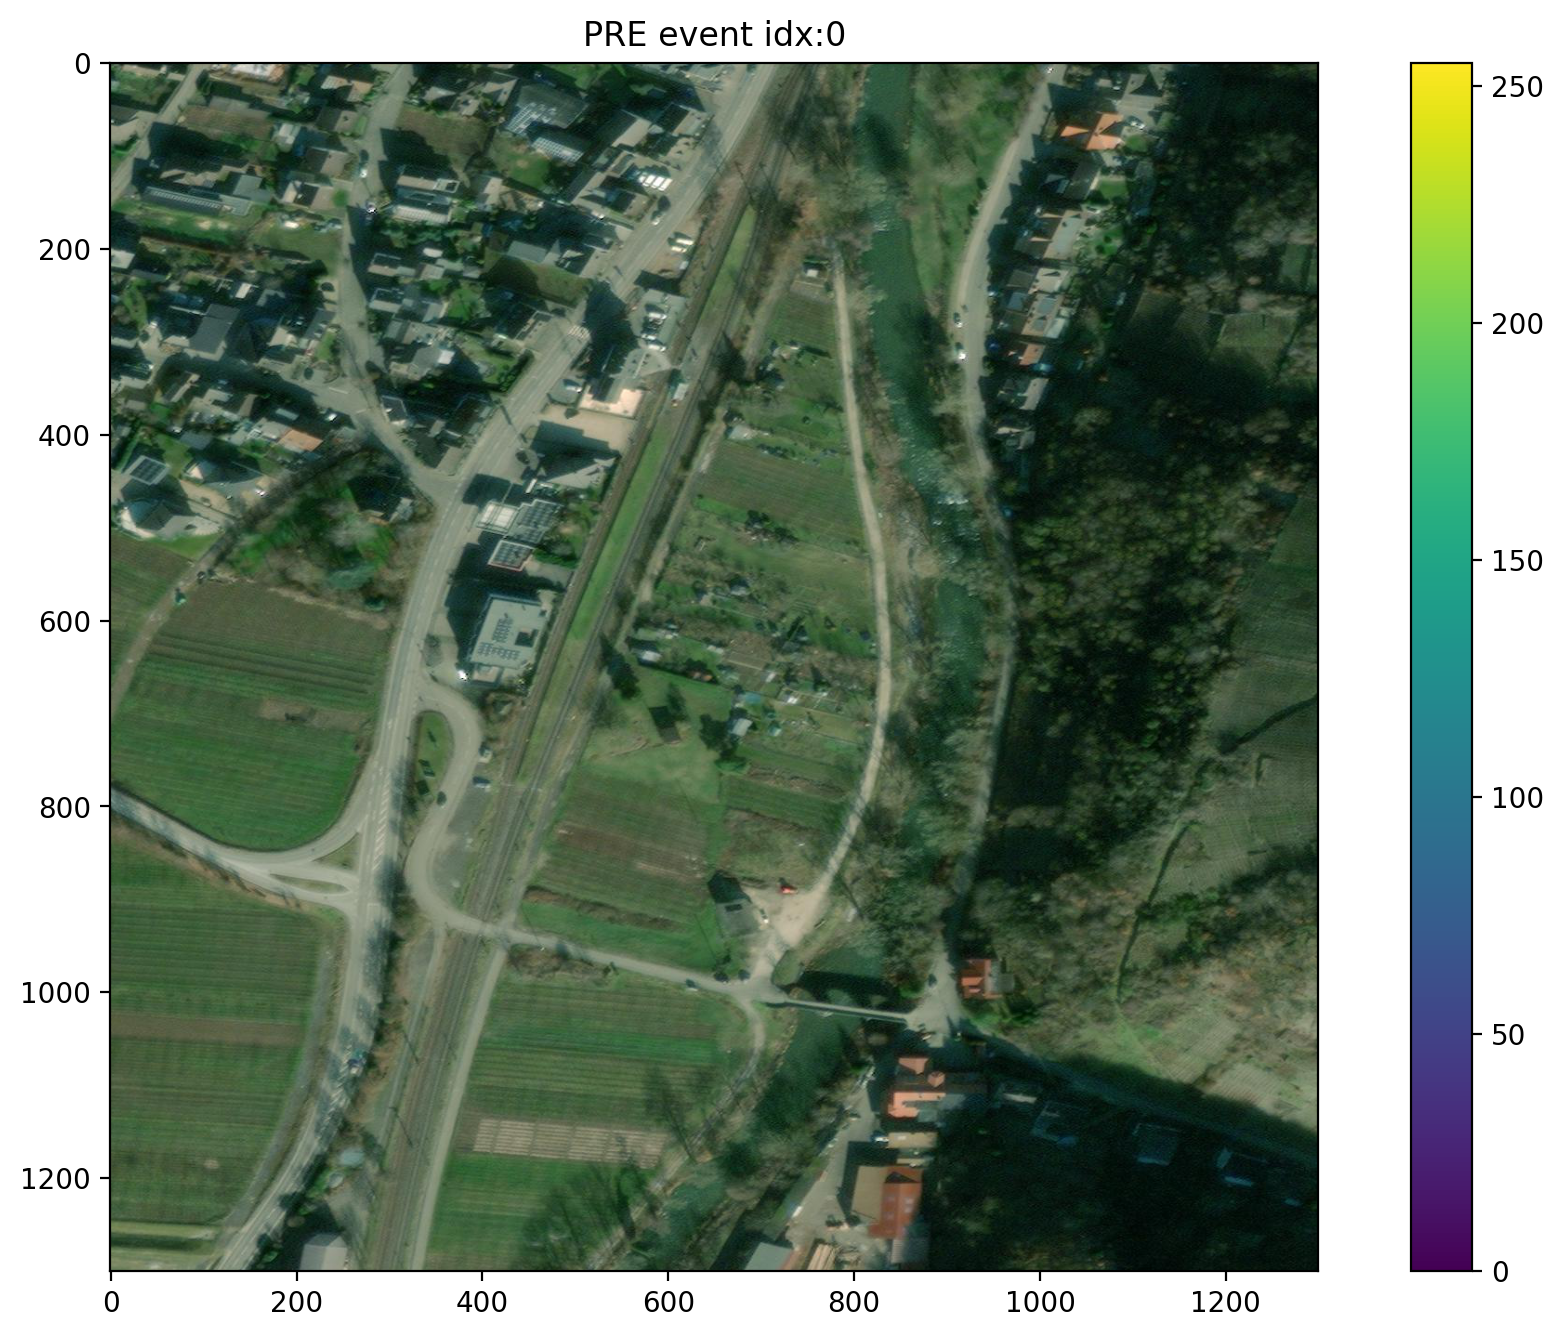

In [79]:
with rio.open(PATH_PRE) as img :
    img = img.read()

plt.figure(figsize=(12, 8), dpi=200)
plt.title(f'PRE event idx:{idx}')
plt.imshow(img.transpose(1, 2, 0))
# plt.colorbar()
plt.show();

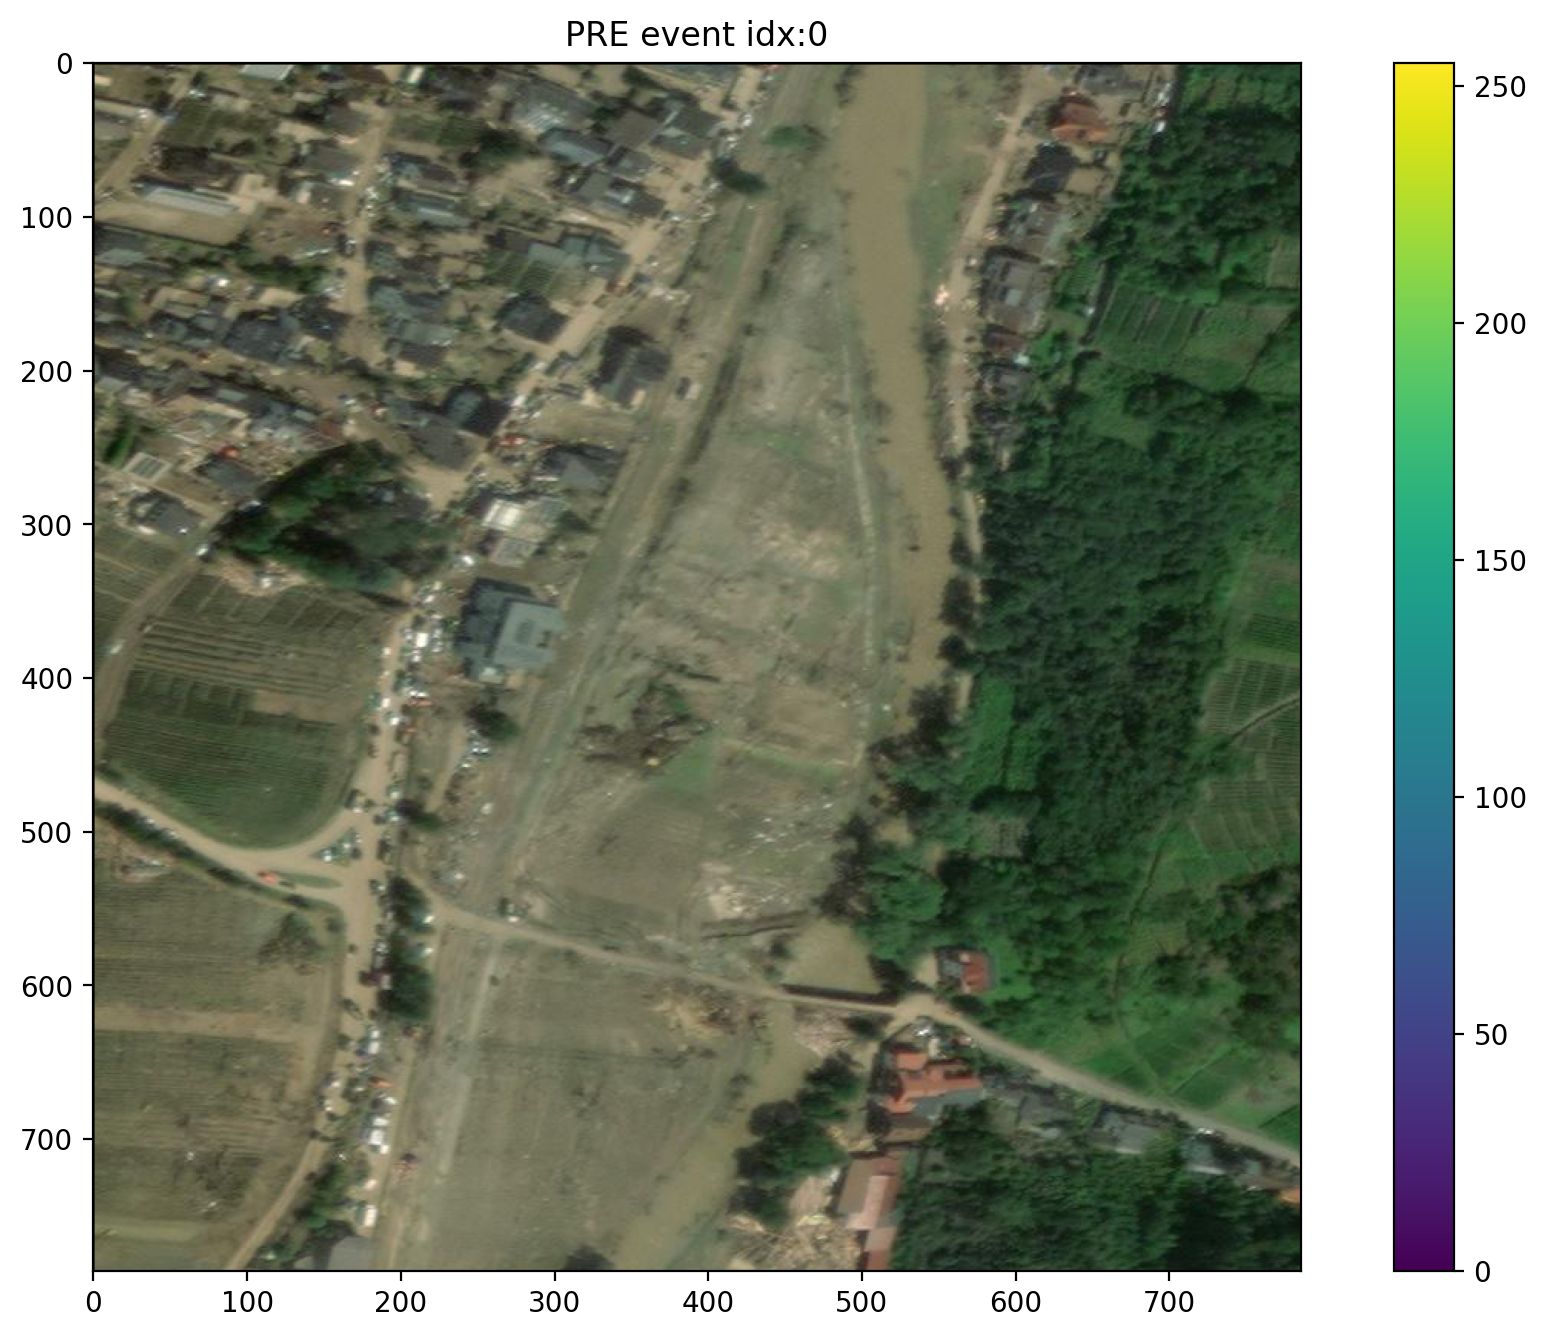

In [80]:
with rio.open(PATH_PST) as img :
    img = img.read()

plt.figure(figsize=(12, 8), dpi=200)
plt.title(f'PRE event idx:{idx}')
plt.imshow(img.transpose(1, 2, 0))
# plt.colorbar()
plt.show();

In [91]:
!gdal_rasterize -ot Byte -burn 128 -burn 255 -burn 255 -ts 1300 1300 -init 0 {PATH_ANO} test.tif

ERROR 1: PROJ: proj_create_from_database: Open of /home/syu/anaconda3/envs/sn8/share/proj failed
0...10...20...30...40...50...60...70...80...90...100 - done.
ERROR 1: PROJ: proj_create_from_database: Open of /home/syu/anaconda3/envs/sn8/share/proj failed


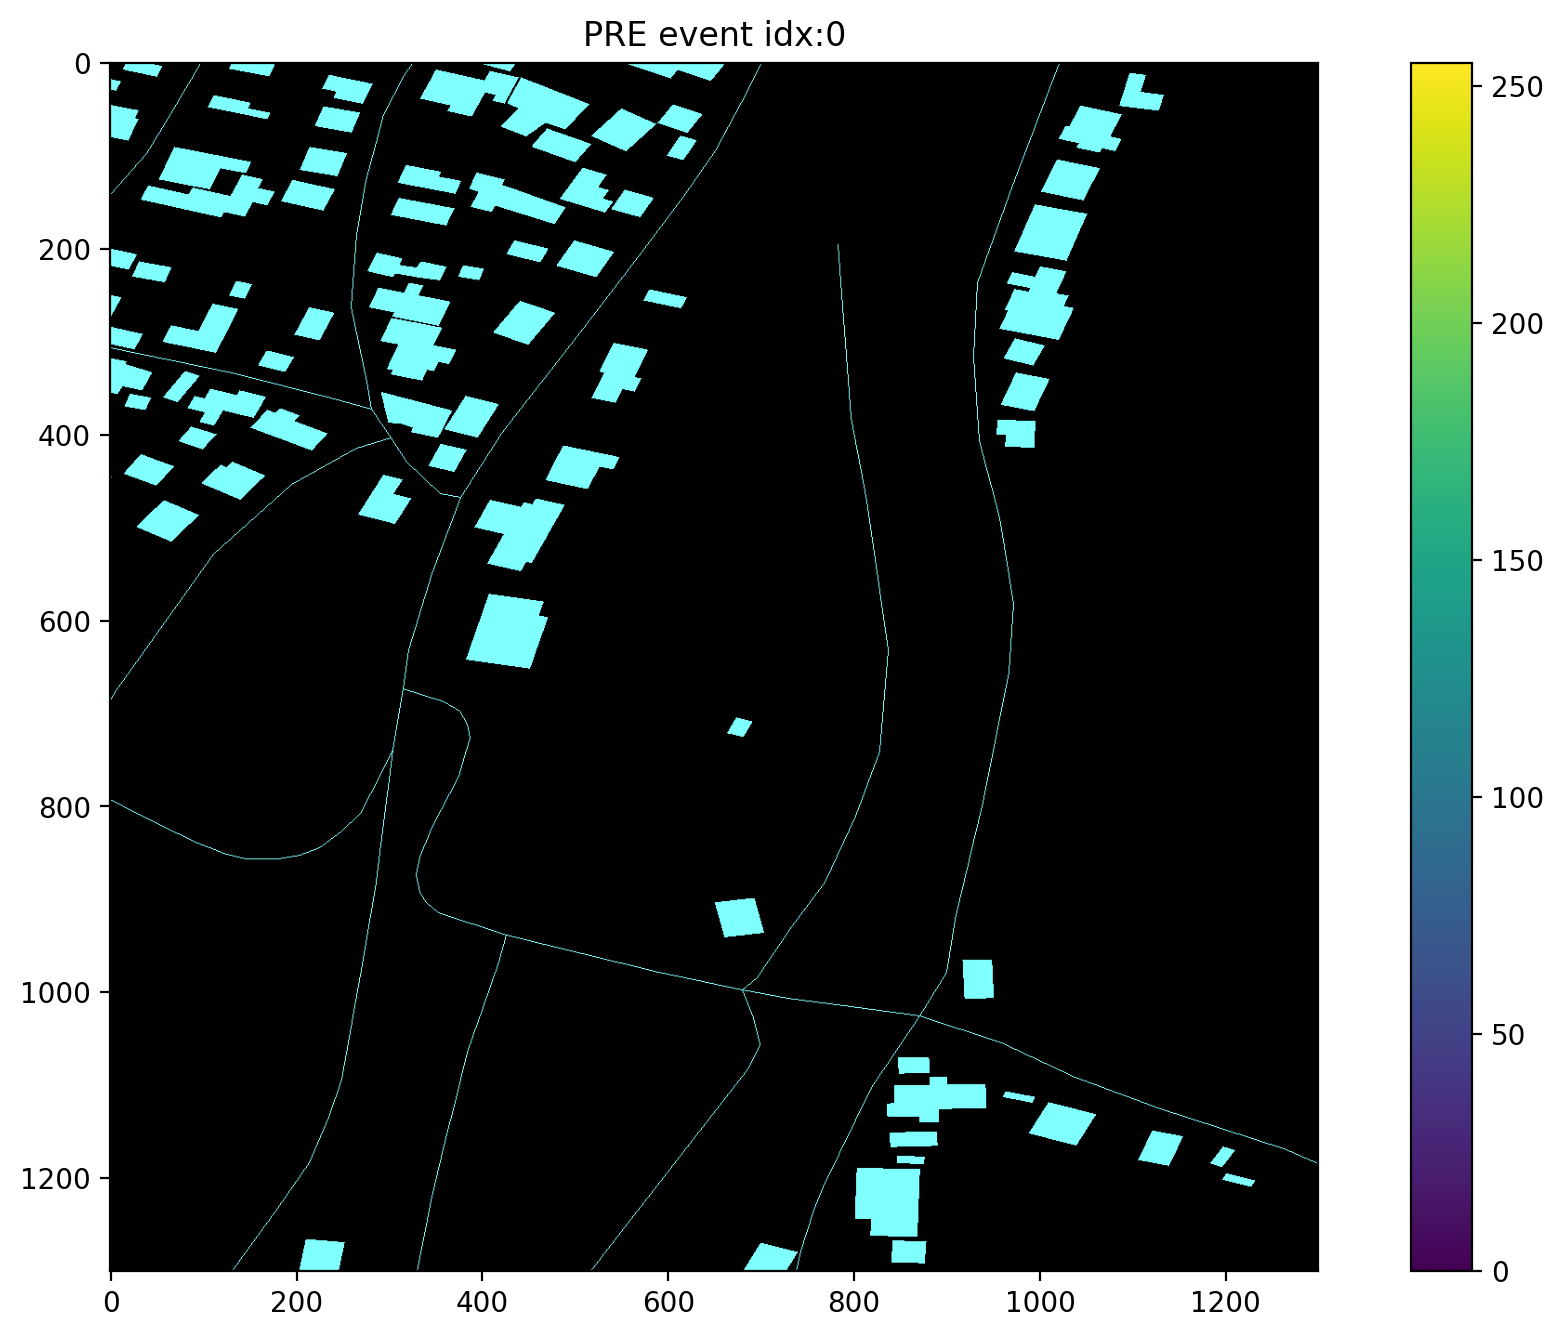

In [92]:
with rio.open('test.tif') as img :
    img = img.read()

plt.figure(figsize=(12, 8), dpi=200)
plt.title(f'PRE event idx:{idx}')
plt.imshow(img.transpose(1, 2, 0))
plt.colorbar()
plt.show();